In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\AI-lab\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\AI-lab\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9753086419753086, Loss: 0.16491805182562935
Checkpoint 200, Accuracy: 0.9753086419753086, Loss: 0.13931590539437752
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.12485076763011792
Checkpoint 400, Accuracy: 0.9753086419753086, Loss: 0.11370917602821633
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.11208064467818649


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.95224303 0.00590125 0.04185566]
[0. 1. 0.] <-> [0.28526354 0.706278   0.00845844]
[1. 0. 0.] <-> [0.9790206  0.01121283 0.00976646]
[1. 0. 0.] <-> [0.9824446  0.0056298  0.01192563]
[1. 0. 0.] <-> [0.94031084 0.00704977 0.05263933]
[1. 0. 0.] <-> [0.9693904  0.02233855 0.00827112]
[1. 0. 0.] <-> [0.9751638  0.01925131 0.00558484]
[1. 0. 0.] <-> [0.9824008  0.00786841 0.00973093]
[1. 0. 0.] <-> [0.7562781  0.00589678 0.23782508]
[1. 0. 0.] <-> [0.97677976 0.00571185 0.01750832]
[1. 0. 0.] <-> [0.98459923 0.00821416 0.00718662]
[1. 0. 0.] <-> [0.9855062  0.00643639 0.00805746]
[0. 0. 1.] <-> [0.08757634 0.00096645 0.9114572 ]
[1. 0. 0.] <-> [0.9841855  0.00686015 0.0089543 ]
[0. 0. 1.] <-> [0.51629764 0.0043498  0.47935256]
[1. 0. 0.] <-> [0.98377335 0.00855513 0.00767155]
[1. 0. 0.] <-> [0.9391254  0.00574652 0.05512805]
[1. 0. 0.] <-> [0.97927666 0.0124578  0.00826562]
[0. 1. 0.] <-> [0.47735974 0.49152112 0.03111914]
[1. 0. 0.] <-> [0.9854381  0.0108108  0.00375103]


In [12]:
# Testing Performance

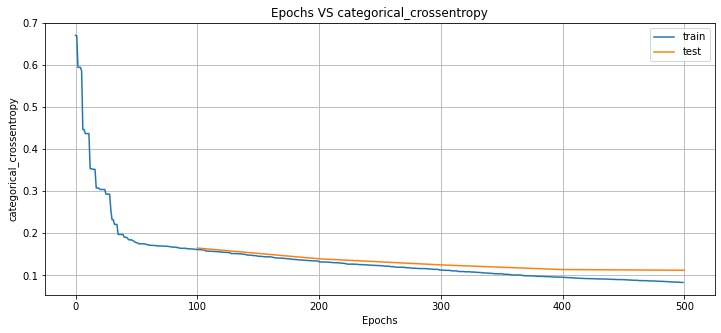

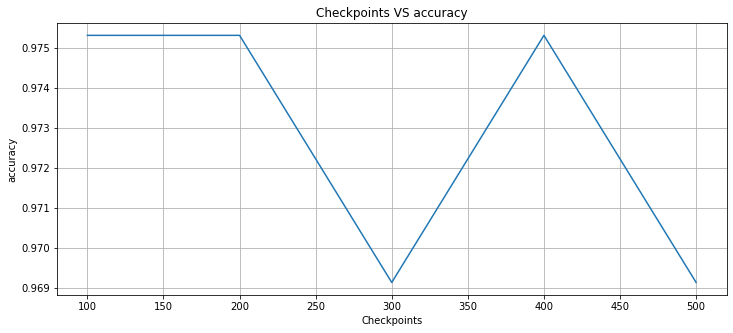

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9753086419753086, 'mean_square_error': 0.07771967179214985, 'categorical_crossentropy': 0.16491805182562935, 'precision': 0.9629629629629629, 'recall': 0.9629629629629629, 'f1': 0.9629629629629629, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 3, 'tn_hit': 29, 'fn_hit': 1}, 1: {'tp_hit': 15, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 2}, 2: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 1}}, 'checkpoint': 100} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.06317951165282991, 'categorical_crossentropy': 0.13931590539437752, 'precision': 0.9629629629629629, 'recall': 0.9629629629629629, 'f1': 0.9629629629629629, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 3, 'tn_hit': 29, 'fn_hit': 1}, 1: {'tp_hit': 15, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 2}, 2: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 1}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.05643977506022683, 'categorical_crossentropy': 0.12485076763011792, 'preci

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[-0.01534451 -0.27592394 -0.08325083  1.9720838   1.3757577 ]
 bias: 1.1609382629394531

Neuron 1: weights:
[-0.48044857  2.563208    1.2408546  -0.9860114  -2.1727812 ]
 bias: 2.6670875549316406

Neuron 2: weights:
[ 1.798125  -2.4357316 -1.0209012  1.1397172  1.3822147]
 bias: 2.7080588340759277

Neuron 3: weights:
[ 0.97433347 -2.5071888  -2.8340135  -0.18031937  1.410877  ]
 bias: 2.9326040744781494

$
Layer 2
Neuron 0: weights:
[-1.8427018  2.9814641  1.1456152  2.573721 ]
 bias: -2.863002300262451

Neuron 1: weights:
[-0.5769117  2.7231112 -1.8336034 -3.       ]
 bias: -0.08242649585008621

Neuron 2: weights:
[ 1.5988728 -3.         2.6410751 -1.3929657]
 bias: -1.4906190633773804

$

